1. FCN
FCN原理及网络结构
FCN首先将一幅RGB图像输入到卷积神经网络后，经过多次卷积以及池化过程得到一系列的特征图，然后利用反卷积层对最后一个卷积层得到的特征图进行上采样，使得上采样后特征图与原图像的大小一样，从而实现对特征图上的每个像素值进行预测的同时保留其在原图像中的空间位置信息，最后对上采样特征图进行逐像素分类，逐个像素计算softmax分类损失。

主要特点：

不含全连接层（FC）的全卷积（Fully Conv）网络。从而可适应任意尺寸输入。

引入增大数据尺寸的反卷积（Deconv）层。能够输出精细的结果。

结合不同深度层结果的跳级（skip）结构。同时确保鲁棒性和精确性。

2. SegNet
Segnet是用于进行像素级别图像分割的全卷积网络，分割的核心组件是一个encoder 网络，及其相对应的decoder网络，后接一个象素级别的分类网络。

encoder网络：其结构与VGG16网络的前13层卷积层的结构相似。decoder网络：作用是将由encoder的到的低分辨率的feature maps 进行映射得到与输入图像featuremap相同的分辨率进而进行像素级别的分类。

Segnet的亮点：decoder进行上采样的方式，直接利用与之对应的encoder阶段中进行max-pooling时的polling index 进行非线性上采样，这样做的好处是上采样阶段就不需要进行学习。 上采样后得到的feature maps 是非常稀疏的，因此，需要进一步选择合适的卷积核进行卷积得到dense featuremaps 。



3. U-net对称语义分割模型，该网络模型主要由一个收缩路径和一个对称扩张路径组成，收缩路径用来获得上下文信息，对称扩张路径用来精确定位分割边界。U-net使用图像切块进行训练，所以训练数据量远远大于训练图像的数量，这使得网络在少量样本的情况下也能获得不变性和鲁棒性。

4. DeepLab
基于全卷积对称语义分割模型得到的分割结果比较粗糙，忽略了像素与像素之间的空间一致性关系。于是Google提出了一种新的扩张卷积语义分割模型，考虑了像素与像素之间的空间一致性关系，可以在不增加数量的情况下增加感受野。

Deeplabv1是由深度卷积网路和概率图模型级联而成的语义分割模型，由于深度卷积网路在重复最大池化和下采样的过程中会丢失很多的细节信息，所以采用扩张卷积算法增加感受野以获得更多上下文信息。考虑到深度卷积网路在图像标记任务中的空间不敏感性限制了它的定位精度，采用了完全连接条件随机场（Conditional Random Field， CRF）来提高模型捕获细节的能力。
Deeplabv2予以分割模型增加了ASPP（Atrous spatial pyramid pooling）结构，利用多个不同采样率的扩张卷积提取特征，再将特征融合以捕获不同大小的上下文信息。
Deeplabv3语义分割模型，在ASPP中加入了全局平均池化，同时在平行扩张卷积后添加批量归一化，有效地捕获了全局语义信息。
DeepLabV3+语义分割模型在Deeplabv3的基础上增加了编-解码模块和Xception主干网路，增加编解码模块主要是为了恢复原始的像素信息，使得分割的细节信息能够更好的保留，同时编码丰富的上下文信息。增加Xception主干网络是为了采用深度卷积进一步提高算法的精度和速度。在inception结构中，先对输入进行11卷积，之后将通道分组，分别使用不同的33卷积提取特征，最后将各组结果串联在一起作为输出。


In [2]:

import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torchvision
from torchvision import transforms as T
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import albumentations as A



class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode

        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])

    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2, -1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims

    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc


def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(False)
    pth = torch.load('./weights/fcn_resnet50_coco-1167a1af.pth')
    for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
        del pth[key]
    model.load_state_dict(pth)
    #model = torchvision.models.segmentation.deeplabv3_resnet101(True)
    #model = torchvision.models.segmentation
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    print(model.eval())
    return model




True


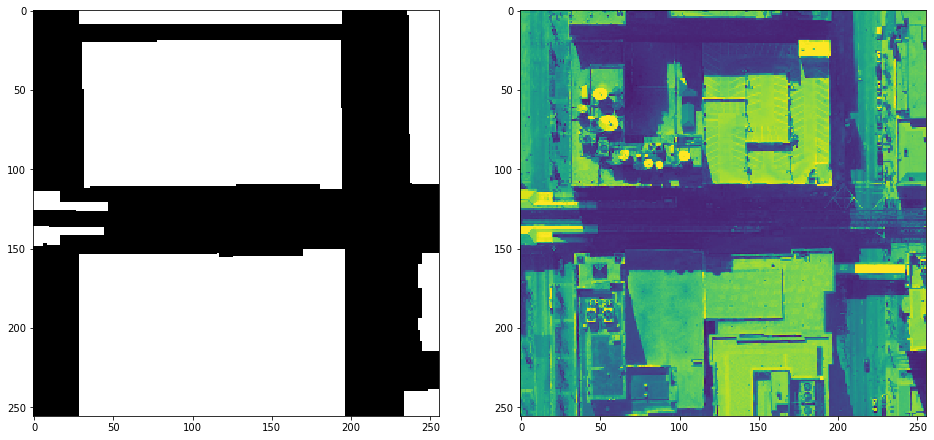

In [4]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.RandomContrast(p=1),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.RandomRotate90(),
])


train_mask = pd.read_csv('train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: './train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])


image, mask = dataset[0]
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0])
plt.show()


In [9]:
import segmentation_models_pytorch as smp
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation


# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)
#model = get_model()

model.to(DEVICE)

pred_mask = model(image)['out']
image, mask = dataset[0]
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(pred_mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0])
plt.show()


AssertionError: Torch not compiled with CUDA enabled